In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

import mmcv
import mmengine
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

2.1.1+cu121 True
1.2.1


In [2]:
data_root = '/workspaces/yj_xq_661_final_project/data'
img_dir = 'img_for_inference_2d'
ann_dir = 'annotation_2d_binary'

classes = ('background', 'fluid')

In [3]:
@DATASETS.register_module()
class BOE_Chiu_Dataset(BaseSegDataset):
    METAINFO = dict(classes = classes)
    def __init__(self,dataset=None, times=None, **kwargs):
        super(BOE_Chiu_Dataset, self).__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [4]:
# # Download config and checkpoint files
#!mim download mmsegmentation --config unet-s5-d16_pspnet_4xb4-40k_hrf-256x256 --dest .

In [5]:
from mmengine import Config
cfg = Config.fromfile('/workspaces/yj_xq_661_final_project/src/unet-s5-d16_pspnet_4xb4-40k_hrf-256x256.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        256,
        256,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/HRF'
dataset_type = 'HRFDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
img_scale =

In [6]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (288, 288)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'BOE_Chiu_Dataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 2

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', scale=(512, 512), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = '/workspaces/yj_xq_661_final_project/data/splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = '/workspaces/yj_xq_661_final_project/data/splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/unet_try_crop_3'

cfg.train_cfg.max_iters = 400
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    288,
    288,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        256,
        256,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '/workspaces/yj_xq_661_final_project/data'
dataset_type = 'BOE_Chiu_Dataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1

In [7]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

12/06 01:43:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Nov 16 2023, 19:48:55) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla V100-PCIE-16GB
    CUDA_HOME: None
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.1+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_7

/home/codespace/.python/current/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/codespace/.python/current/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/codespace/.python/current/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/06 01:43:40 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
12/06 01:43:40 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/codespace/.python/current/lib/python3.10/site-packages/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [8]:
# start training
runner.train()

12/06 01:43:41 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth
12/06 01:43:42 - mmengine - INFO - Load checkpoint from pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth
12/06 01:43:42 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
12/06 01:43:42 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
12/06 01:43:42 - mmengine - INFO - Checkpoints will be saved to /workspaces/yj_xq_661_final_project/src/work_dirs/unet_try_crop_3.
12/06 01:43:55 - mmengine - INFO - Iter(train) [ 10/400]  lr: 9.9980e-03  eta: 0:08:27  time: 1.3008  data_time: 0.0041  memory: 9434  loss: 0.1485  decode.loss_ce: 0.1068  decode.acc_seg: 95.1130  aux.loss_ce: 0.0417  aux.acc_seg: 95.1118
12/06 0

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): UNet(
    (encoder): ModuleList(
      (0): Sequential(
        (0): BasicConvBlock(
          (convs): Sequential(
            (0): ConvModule(
              (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): ReLU(inplace=True)
            )
            (1): ConvModule(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): ReLU(inplace=True)
            )
          )
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): BasicConvBlock(
          (convs): Sequential(
            (0): ConvModule(
    

In [9]:
# from mmseg.apis import init_model, inference_model, show_result_pyplot

# # Init the model from the config and the checkpoint
# checkpoint_path = './work_dirs/unet_try_3/iter_200.pth'
# model = init_model(cfg, checkpoint_path, 'cuda:0')

In [10]:
# for i in range(110):
#     img = mmcv.imread(f'/workspaces/YJ_661_final_project/data/img_for_inference_2d/img_{i}.png')
#     result = inference_model(model, img)
#     plt.figure(figsize=(8, 6))
#     vis_result = show_result_pyplot(model, img, result)
#     plt.imshow(mmcv.bgr2rgb(vis_result))

In [11]:
#load data from json file
import json

In [15]:
vis_data_path = '/workspaces/yj_xq_661_final_project/src/work_dirs/unet_try_crop_3/20231206_014336/vis_data/scalars.json'
with open(vis_data_path) as f:
    data_viz = [json.loads(line) for line in f]

loss = []
# for i in range(len(data_viz)-1):
#     loss.append(data_viz[i]['loss'])
for i in range(20):
    loss.append(data_viz[i]['loss'])

for i in range(21, len(data_viz)-1):
    loss.append(data_viz[i]['loss'])

In [16]:
loss

[0.1484934650361538,
 0.057384759187698364,
 0.07495386172086001,
 0.040574062056839465,
 0.05332055017352104,
 0.058091547712683676,
 0.04195647239685059,
 0.04161001844331622,
 0.03781277518719435,
 0.04033131487667561,
 0.04764324026182294,
 0.03330687014386058,
 0.026890171319246294,
 0.02897857241332531,
 0.038494968041777614,
 0.03699511354789138,
 0.03548940373584628,
 0.022895894944667816,
 0.02980082333087921,
 0.04096906716004014,
 0.026384217385202646,
 0.027621411718428135,
 0.03392173266038299,
 0.03483940390869975,
 0.034730853512883186,
 0.017463272996246816,
 0.03977803895249963,
 0.025203817710280418,
 0.02221434274688363,
 0.02689269222319126,
 0.036854679323732854,
 0.03214281280525029,
 0.02829711646772921,
 0.029008852317929268,
 0.028908602707087994,
 0.029125121608376502,
 0.03513422878459096,
 0.025685123261064292,
 0.02051827497780323,
 0.028914078790694474]

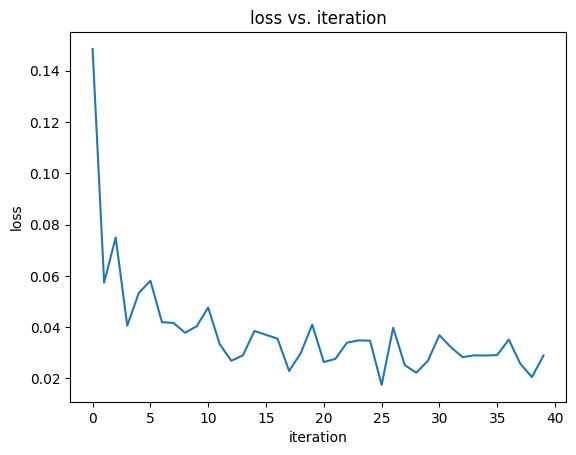

In [17]:
#plot loss vs. iteration
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs. iteration')
plt.show()